In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from scipy.stats import loguniform
import time

# ========== 1. CONFIGURACIÓN ==========
dataset_path = "dataset"  # ← Cambia esta ruta si tu carpeta se llama distinto
target_size = (62, 47)    # Mismo tamaño que el ejemplo oficial (LFW con resize=0.4)
min_confidence = 0.8      # Umbral del 80%

In [2]:
# ========== 2. CARGAR DATOS ==========
print("Cargando imágenes desde:", dataset_path)
images = []
labels = []

for person_name in sorted(os.listdir(dataset_path)):
    person_dir = os.path.join(dataset_path, person_name)
    if not os.path.isdir(person_dir):
        continue
    for img_file in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_file)
        try:
            img = io.imread(img_path)
            # Convertir a escala de grises si es necesario
            if img.ndim == 3:
                img = color.rgb2gray(img)
            elif img.ndim == 2:
                pass  # ya es gris
            else:
                continue
            img_resized = resize(img, target_size, anti_aliasing=True)
            images.append(img_resized.flatten())
            labels.append(person_name)
        except Exception as e:
            print(f"Saltando archivo dañado: {img_path} - {e}")

images = np.array(images, dtype=np.float32)
labels = np.array(labels)

if len(images) == 0:
    raise ValueError("¡No se cargaron imágenes! Revisa la ruta y estructura de carpetas.")

print(f"\n✅ Cargadas {len(images)} imágenes de {len(np.unique(labels))} personas.")


Cargando imágenes desde: dataset

✅ Cargadas 700 imágenes de 10 personas.

✅ Cargadas 700 imágenes de 10 personas.


In [3]:
# ========== 3. PREPARAR DATOS ==========
le = LabelEncoder()
y = le.fit_transform(labels)
X = images

# Dividir
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Normalizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
# ========== 4. PCA (Eigenfaces) ==========
n_components = min(150, X_train.shape[0])
print(f"\n🔍 Extrayendo las primeras {n_components} eigenfaces de {X_train.shape[0]} caras...")
t0 = time.time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"✅ PCA completado en {time.time() - t0:.2f}s")



🔍 Extrayendo las primeras 150 eigenfaces de 525 caras...
✅ PCA completado en 0.10s


In [5]:
# ========== 5. ENTRENAR SVM CON VALIDACIÓN ==========
print("\n⚙️ Entrenando clasificador SVM con búsqueda de hiperparámetros...")
t0 = time.time()
param_grid = {
    "C": loguniform(1e2, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
svm = SVC(kernel="rbf", class_weight="balanced", probability=True)  # ← ¡probabilidad activada!
clf = RandomizedSearchCV(svm, param_grid, n_iter=15, cv=3, random_state=42, n_jobs=-1)
clf.fit(X_train_pca, y_train)
print(f"✅ Entrenamiento completado en {time.time() - t0:.2f}s")
print("Mejor modelo:", clf.best_estimator_)



⚙️ Entrenando clasificador SVM con búsqueda de hiperparámetros...


✅ Entrenamiento completado en 5.09s
Mejor modelo: SVC(C=np.float64(15702.970884055372), class_weight='balanced',
    gamma=np.float64(0.006251373574521752), probability=True)


In [6]:
# ========== 6. PREDICCIÓN CON UMBRAL DE 80% ==========
print(f"\n🔮 Prediciendo con umbral de confianza ≥{min_confidence*100:.0f}%...")

# Obtener probabilidades
y_proba = clf.predict_proba(X_test_pca)
y_pred_raw = clf.predict(X_test_pca)

# Aplicar umbral
y_pred = []
y_test_with_unknown = []  # para métricas coherentes, filtramos solo conocidos
y_pred_known = []

for i, probas in enumerate(y_proba):
    max_prob = np.max(probas)
    pred_class = y_pred_raw[i]
    true_class = y_test[i]
    
    if max_prob >= min_confidence:
        y_pred.append(le.inverse_transform([pred_class])[0])
        y_pred_known.append(pred_class)
        y_test_with_unknown.append(true_class)
    else:
        y_pred.append("Desconocido")

# Convertir a etiquetas originales
y_test_names = le.inverse_transform(y_test)



🔮 Prediciendo con umbral de confianza ≥80%...


In [7]:
# ========== 7. EVALUACIÓN ==========
print("\n📊 Resultados en test (solo predicciones ≥80% de confianza):")
# Mostrar cuántos fueron "Desconocido"
num_unknown = y_pred.count("Desconocido")
print(f" - {num_unknown} imágenes clasificadas como 'Desconocido'")
print(f" - {len(y_pred) - num_unknown} clasificadas con ≥80% confianza")
all_labels = le.transform(le.classes_)  # [0, 1, 2, ..., n_classes-1]

# Métricas solo sobre los clasificados (evita "Desconocido")
if len(y_pred_known) > 0:
    print("\n📋 Reporte de clasificación (solo predicciones confiables):")
    # Aseguramos que las etiquetas usadas sean todas las originales

    print(classification_report(
        y_true=np.array(y_test_with_unknown),
        y_pred=np.array(y_pred_known),
        labels=all_labels,
        target_names=le.classes_,
        zero_division=0
    ))
else:
    print("⚠️ Ninguna predicción superó el umbral del 80%.")



📊 Resultados en test (solo predicciones ≥80% de confianza):
 - 139 imágenes clasificadas como 'Desconocido'
 - 36 clasificadas con ≥80% confianza

📋 Reporte de clasificación (solo predicciones confiables):
              precision    recall  f1-score   support

    persona1       1.00      1.00      1.00         4
   persona10       1.00      1.00      1.00         4
    persona2       1.00      1.00      1.00         2
    persona3       1.00      1.00      1.00         4
    persona4       1.00      1.00      1.00         2
    persona5       1.00      1.00      1.00         3
    persona6       1.00      1.00      1.00         7
    persona7       1.00      1.00      1.00         2
    persona8       0.00      0.00      0.00         4
    persona9       0.33      0.50      0.40         4

    accuracy                           0.83        36
   macro avg       0.83      0.85      0.84        36
weighted avg       0.81      0.83      0.82        36



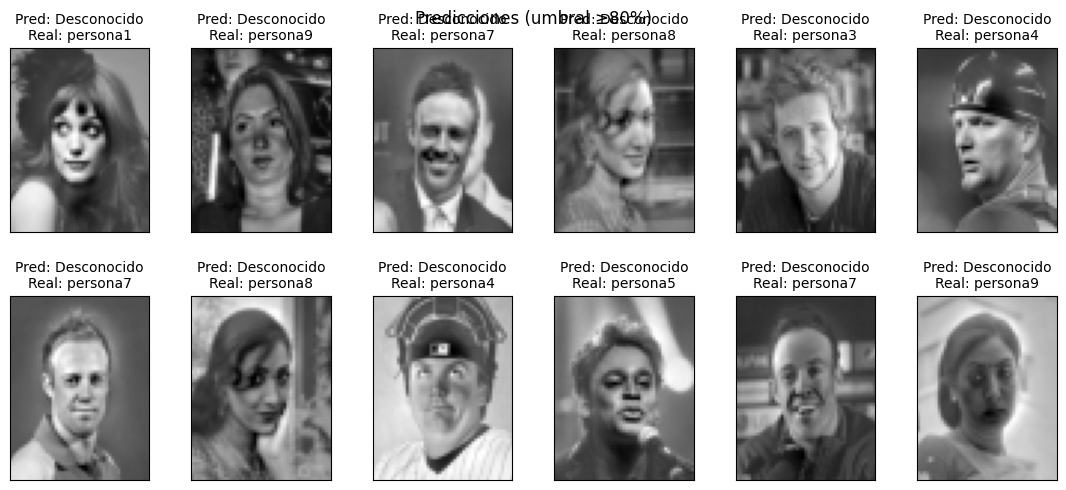

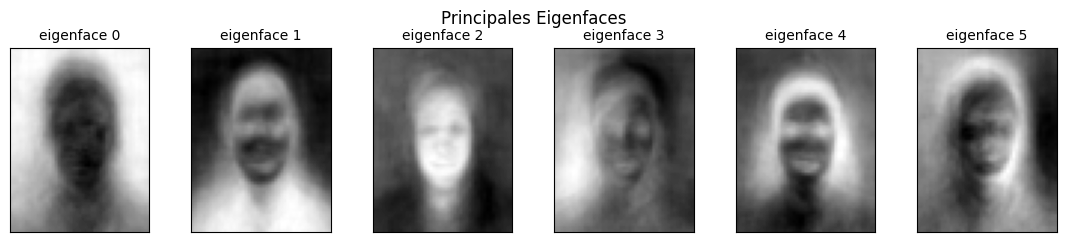

In [8]:
# ========== 8. VISUALIZACIÓN ==========
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=10)
        plt.xticks(())
        plt.yticks(())

h, w = target_size
titles = [f"Pred: {p}\nReal: {r}" for p, r in zip(y_pred[:12], y_test_names[:12])]
plot_gallery(X_test[:12], titles, h, w)
plt.suptitle("Predicciones (umbral ≥80%)")
plt.show()

# Mostrar eigenfaces principales
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces[:6], eigenface_titles[:6], h, w)
plt.suptitle("Principales Eigenfaces")
plt.show()

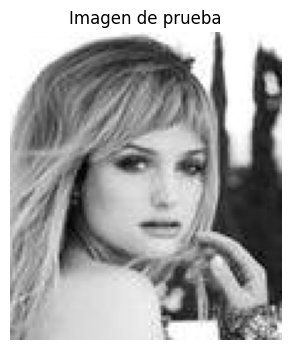


✅ Reconocido: persona1 (0.96)


/Users/bryan/Desktop/fas/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


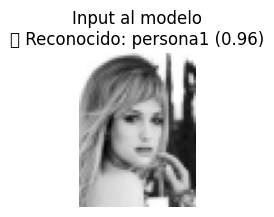

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize

# ====== CONFIGURACIÓN ======
image_path = "dataset/persona1/0060_01.jpg"  # ← ¡Cambia esta ruta!
target_size = (62, 47)  # ← debe ser la misma que usaste al entrenar
min_confidence = 0.8

# ====== CARGAR E IMAGEN ======
img = io.imread(image_path)

# Convertir a escala de grises si es necesario
if img.ndim == 3:
    img_gray = color.rgb2gray(img)
else:
    img_gray = img

# Mostrar imagen original
plt.figure(figsize=(4, 4))
plt.imshow(img_gray, cmap='gray')
plt.title("Imagen de prueba")
plt.axis('off')
plt.show()

# ====== PREPROCESAMIENTO ======
# Redimensionar al tamaño usado en entrenamiento
img_resized = resize(img_gray, target_size, anti_aliasing=True)
img_flat = img_resized.flatten().reshape(1, -1)

# Aplicar mismo preprocesamiento que en entrenamiento
img_scaled = scaler.transform(img_flat)
img_pca = pca.transform(img_scaled)

# ====== PREDICCIÓN ======
probas = clf.predict_proba(img_pca)[0]
max_prob = np.max(probas)
pred_class = clf.predict(img_pca)[0]

# Aplicar umbral
if max_prob >= min_confidence:
    predicted_name = le.inverse_transform([pred_class])[0]
    result = f"✅ Reconocido: {predicted_name} ({max_prob:.2f})"
else:
    predicted_name = "Desconocido"
    result = f"❌ {predicted_name} (confianza: {max_prob:.2f} < {min_confidence})"

print("\n" + "="*50)
print(result)
print("="*50)

# ====== OPCIONAL: Mostrar imagen redimensionada ======
plt.figure(figsize=(2, 2))
plt.imshow(img_resized, cmap='gray')
plt.title(f"Input al modelo\n{result}")
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
from skimage import color, transform

# ====== CONFIGURACIÓN ======
target_size = (62, 47)  # Debe coincidir con el entrenamiento
min_confidence = 0.8

# Cargar el clasificador de rostros de OpenCV (Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Inicializar la cámara
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir a escala de grises para la detección de rostros
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostros
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extraer el rostro
        face_img = gray[y:y+h, x:x+w]

        # Redimensionar y preprocesar igual que en el entrenamiento
        face_resized = transform.resize(face_img, target_size, anti_aliasing=True)
        face_flat = face_resized.flatten().reshape(1, -1)
        face_scaled = scaler.transform(face_flat)
        face_pca = pca.transform(face_scaled)

        # Predecir
        probas = clf.predict_proba(face_pca)[0]
        max_prob = np.max(probas)
        pred_class = clf.predict(face_pca)[0]

        # Aplicar umbral
        if max_prob >= min_confidence:
            predicted_name = le.inverse_transform([pred_class])[0]
            label = f"{predicted_name} ({max_prob:.2f})"
            color = (0, 255, 0)  # Verde
        else:
            label = f"Desconocido ({max_prob:.2f})"
            color = (0, 0, 255)  # Rojo

        # Dibujar rectángulo y etiqueta
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Mostrar el frame
    cv2.imshow('Reconocimiento Facial', frame)

    # Salir con 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


: 